<a href="https://colab.research.google.com/github/paschmaria/Data-Science-Projects/blob/master/TwitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Library for emoji
import emoji
import json
import keras
import nltk
import os
import re
import sklearn
import keras.preprocessing.text as kpt
import matplotlib.pyplot as plt
# import mysql.connector as mysql
import numpy as np
import pandas as pd
import seaborn as sns

from keras.layers import Dense, Dropout, Activation;
from keras.models import (
    Sequential,
    model_from_json
)
#Import nltk to check english lexicon
from nltk.corpus import (
    wordnet,
    stopwords
)
from nltk.tokenize import word_tokenize
from PIL import Image
#To anotate database
from pycorenlp import StanfordCoreNLP
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sqlalchemy import create_engine
from textblob import TextBlob
from tqdm import tqdm
from wordcloud import WordCloud

# import twitter and db credentials
# from settings import *

Using TensorFlow backend.


In [0]:
#Querying the database
def query_database(tweets):
#     engine = create_engine(f"mysql+mysqlconnector://{DBUSER}:{DBPASSWORD}@{DBHOST}/{DB}")
  columns = ['created_at','tweet','user_id','user_name','retweetstatus_user','retweetstatus_name']
  table = pd.read_csv('tweets_predict_mondaymotivation.csv', index_col=0, names=columns)
  return table

## Create tweet labels

Let's label tweets as either positive or negative

In [0]:
def create_labels(table):
    sentences = [TextBlob(x).sentences for x in table['tweet']]
    polarity = []
    for i in sentences:
        if len(i) == 1:
            for j in i:
                polarity.append(j.sentiment.polarity)
        else:
            polarity.append(0.0)
    table['sentiments'] = [1 if x >= 0.0 else 0 for x in polarity]
    return table

## Text Preprocessing

In [0]:
#preprocess text in tweets by removing links, @UserNames, blank spaces, etc.
def preprocessing_text(table):
    #put everythin in lowercase
    table['tweet'] = table['tweet'].str.lower()
    #Replace rt indicating that was a retweet
    table['tweet'] = table['tweet'].str.replace('rt', '')
    #Replace occurences of mentioning @UserNames
    table['tweet'] = table['tweet'].replace(r'@\w+', '', regex=True)
    #Replace links contained in the tweet
    table['tweet'] = table['tweet'].replace(r'http\S+', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'www.[^ ]+', '', regex=True)
    #remove numbers
    table['tweet'] = table['tweet'].replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    table['tweet'] = table['tweet'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    return table

In [0]:
#Replace elongated words (words with repeating character more than two times) and compare the new word with the english lexicon
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    # check if word is shortened
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    # get elongated words
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            # if word not in english lexicon, replace word with shortened word
            row = re.sub(word, replace_elongated_word(word), row)
    return row

In [0]:
#We need to remove the stop words like with, they, own, an, be, some, for, do
def stop_words(table):
    stop_words_list = stopwords.words('english')
    table['tweet'] = table['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return table

In [0]:
def replace_antonyms(word):
    #We get all the lemma for the word
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            #if the lemma is an antonyms of the word
            if lemma.antonyms(): 
                #we return the antonym
                return lemma.antonyms()[0].name()
    return word
            
def handling_negation(row):
    #Tokenize the row
    words = word_tokenize(row)
    speech_tags = ['JJ', 'JJR', 'JJS', 'NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
    #We obtain the type of words that we have in the text, we use the pos_tag function
    tags = nltk.pos_tag(words)
    tags_2 = ''
    #check for negation in the words
    if "n't" in words and "not" in words:
        tags_2 = tags[min(words.index("n't"), words.index("not")):]
        words_2 = words[min(words.index("n't"), words.index("not")):]
        words = words[:(min(words.index("n't"), words.index("not")))+1]
    elif "n't" in words:
        tags_2 = tags[words.index("n't"):]
        words_2 = words[words.index("n't"):] 
        words = words[:words.index("n't")+1]
    elif "not" in words:
        tags_2 = tags[words.index("not"):]
        words_2 = words[words.index("not"):]
        words = words[:words.index("not")+1]
        
    for index, word_tag in enumerate(tags_2):
        if word_tag[1] in speech_tags:
            words = words+[replace_antonyms(word_tag[0])]+words_2[index+2:]
            break
            
    return ' '.join(words)

In [0]:
def cleaning_table(table):
    #This function will process all the required cleaning for the text in our tweets
    table = preprocessing_text(table)
    table['tweet'] = table['tweet'].apply(lambda x: detect_elongated_words(x))
    table['tweet'] = table['tweet'].apply(lambda x: handling_negation(x))
    table = stop_words(table)
    return table

## Data Visualization

Let's perform an exploratory data analysis to see what are the most frequent words that appear in our 'MondayMotivation' tweets. We will display graphs regarding tweets labelled as positive separated from those labelled as negative.

In [0]:
#Vectorization for Data Visualization
def vectorization(table):
    #CountVectorizer helps to convert a collection of text documents to a matrix of token counts
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table.tweet)
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

In [0]:
def word_cloud(tweets, tweet_word):
    
    #We get the directory that we are working on
    file = os.getcwd()
    #We read the mask image into a numpy array
    mm_image = np.array(Image.open(os.path.join(file, "monday_motivation.jpg")))
    #Now we store the tweets into a series to be able to process 
    #tweets_list = pd.Series([t for t in tweet_table.tweet]).str.cat(sep=' ')  
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, background_color="black", max_words=2000, mask=mm_image, contour_width=1, 
                           contour_color="steelblue", colormap="nipy_spectral", stopwords=[tweet_word])
    word_cloud.generate(tweets)
    
    #wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_list)
    
    #Now we plot both figures, the wordcloud and the mask
    #plt.figure(figsize=(15,15))
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")
    #plt.imshow(avengers_mask, cmap=plt.cm.gray, interpolation="bilinear")
    #plt.axis("off")    
    plt.show()

In [0]:
def graph(word_frequency, sent):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show()

In [0]:
def regression_graph(table):
    table = table[1:]
    #We set the style of seaborn
    sns.set_style("whitegrid")   
    #Initialize the figure
    plt.figure(figsize=(6,6))
    
    #we obtain the points from matplotlib scatter
    points = plt.scatter(table["Positive"], table["Negative"], c=table["Positive"], s=75, cmap="bwr")
    #graph the colorbar
    plt.colorbar(points)
    #we graph the regplot from seaborn
    sns.regplot(x="Positive", y="Negative",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word frequency in Positive vs. Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()

## Train - Test Split / Tokenization

In [0]:
#Split Data into training and test set
def splitting(table):
    X_train, X_test, y_train, y_test = train_test_split(table.tweet, table.sentiments, test_size=0.2, shuffle=True)
    return X_train, X_test, y_train, y_test

In [0]:
#Tokenization for analysis
def tokenization_tweets(dataset, features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(dataset)
    dataset_transformed = tokenization.transform(dataset).toarray()
    return dataset_transformed

## Model Training and Evaluation

In [0]:
def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=validation,
                 shuffle=shuffle)
    return model_nn

def test(X_test, model_nn):
    prediction = model_nn.predict(X_test)
    return prediction

In [0]:
tweet_word = 'mondaymotivation'
tabletweets = f"tweets_predict_{tweet_word}"
tweet_table = query_database(tabletweets)
tweet_table = cleaning_table(tweet_table)
tweet_table = create_labels(tweet_table)

In [0]:
tweet_table

,created_at,tweet,user_id,user_name,retweetstatus_user,retweetstatus_name,sentiments
1,2019-09-10 11:08:36,yes mondaymotivation,1015580496,ThabisoMasilela,457581637,LindoMyeni,1
2,2019-09-10 11:08:37,godmorningmonday holy quran hazrat muhammad ji...,1161914831185649664,Ranjit03924639,2147483647,Manaramdas56,1
3,2019-09-10 11:08:38,guess road securenigeria,990519410082418688,ofmonsters_1,14879097,segalink,1
4,2019-09-10 11:08:43,…,1137858852706226176,LoveBirdsMaine,2147483647,CarmenLLoveB,1
5,2019-09-10 11:08:45,best new starlet vote nelykent mondaymotivation,1146784217315123200,Sentine75169895,702659090,NellyKentXXX,1
6,2019-09-10 11:08:50,wohy potus please vote retwet spread poll than...,75877072,porter1960,2147483647,pollsofpolitics,1
7,2019-09-10 11:08:52,wilie nelson returns good health fine form out...,389294259,vfeliciano71,2147483647,WilliesReserve,1
8,2019-09-10 11:08:59,mondaymotivation faith impoant devotees get sa...,1160559949396627456,Shobha13561013,2147483647,happyneeraj1994,1
9,2019-09-10 11:09:01,mondaymotivation lord kabir true god remove si...,1160559949396627456,Shobha13561013,2147483647,happyneeraj1994,1
10,2019-09-10 11:09:07,always positive mindset unlock new boundaries ...,338452661,timosquare85,989869530,TECNOMobileNG,1


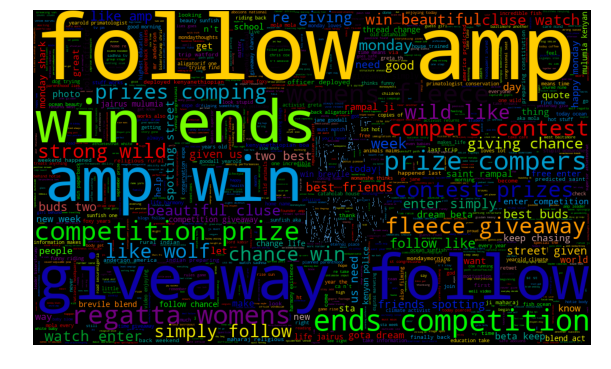

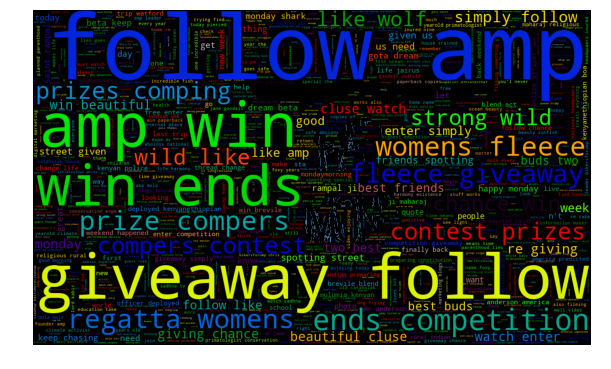

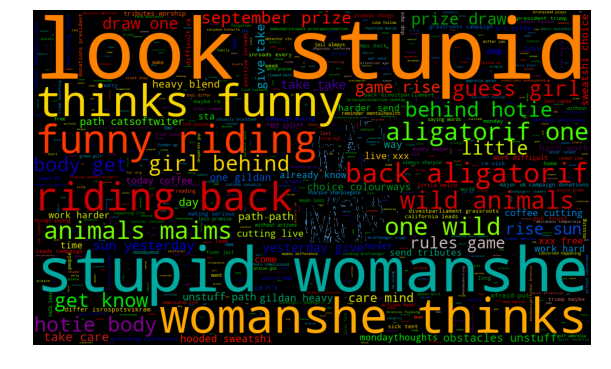

In [0]:
#First we draw a word cloud for all tweets
word_cloud(pd.Series([t for t in tweet_table.tweet]).str.cat(sep=' '), tweet_word)    
#For positive tweets 
word_cloud(pd.Series([t for t in tweet_table[tweet_table.sentiments == 1].tweet]).str.cat(sep=' '), tweet_word)   
#For negative tweets
word_cloud(pd.Series([t for t in tweet_table[tweet_table.sentiments == 0].tweet]).str.cat(sep=' '), tweet_word)

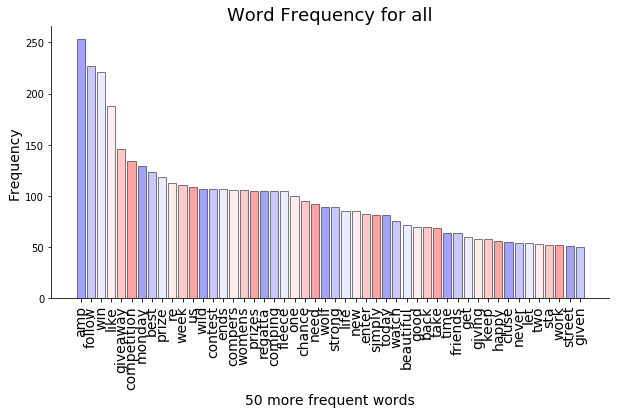

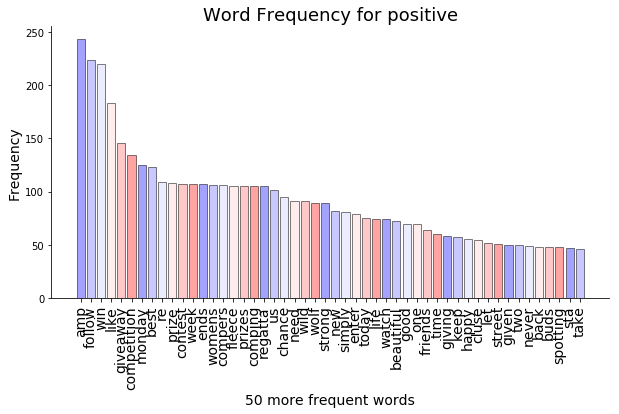

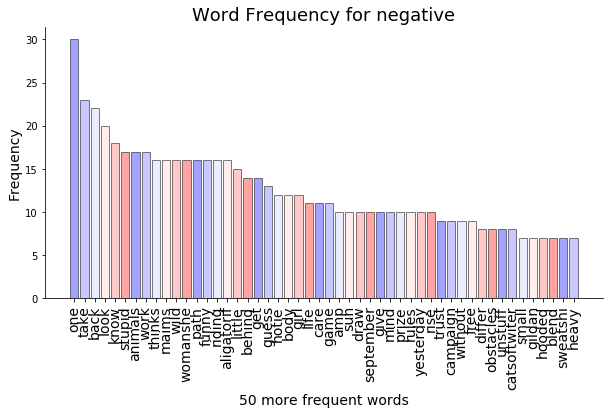

In [0]:
#Get the frequency
word_frequency = vectorization(tweet_table).sort_values(0, ascending = False)
word_frequency_pos = vectorization(tweet_table[tweet_table['sentiments'] == 1]).sort_values(0, ascending = False)
word_frequency_neg = vectorization(tweet_table[tweet_table['sentiments'] == 0]).sort_values(0, ascending = False)

#Graph with frequency words all, positive and negative tweets and get the frequency
graph(word_frequency, 'all')
graph(word_frequency_pos, 'positive')
graph(word_frequency_neg, 'negative')

In [0]:
X_train, X_test, y_train, y_test = splitting(tweet_table)

In [0]:
def model1(X_train, y_train):   
    features = 3500
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.001
    epsilon = None
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model1(X_train, y_train)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1530 samples, validate on 170 samples
Epoch 1/5
1530/1530 [==============================] - 6s 4ms/step - loss: 0.5011 - acc: 0.8209 - val_loss: 0.3170 - val_acc: 0.9000
Epoch 2/5
1530/1530 [==============================] - 0s 167us/step - loss: 0.2474 - acc: 0.9183 - val_loss: 0.2390 - val_acc: 0.9000
Epoch 3/5
1530/1530 [==============================] - 0s 157us/step - loss: 0.1290 - acc: 0.9477 - val_loss: 0.1953 - val_acc: 0.9412
Epoch 4/5
1530/1530 [==============================] - 0s 167us/step - loss: 0.0470 - acc: 0.9824 - val_loss: 0.1780 - val_acc: 0.9529
Epoch 5/5
1530/1530 [==============================] - 0s 158us/step - loss: 0.0213 - acc: 0.9941 - val_loss: 0.1998 - val_acc: 0.9529


In [0]:
def model2(X_train, y_train):   
    features = 3000
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.001
    epsilon = None
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model2(X_train, y_train)

Train on 1530 samples, validate on 170 samples
Epoch 1/5
1530/1530 [==============================] - 1s 364us/step - loss: 0.4262 - acc: 0.8804 - val_loss: 0.3080 - val_acc: 0.9000
Epoch 2/5
1530/1530 [==============================] - 0s 164us/step - loss: 0.2454 - acc: 0.9222 - val_loss: 0.2280 - val_acc: 0.9059
Epoch 3/5
1530/1530 [==============================] - 0s 147us/step - loss: 0.1154 - acc: 0.9582 - val_loss: 0.1806 - val_acc: 0.9412
Epoch 4/5
1530/1530 [==============================] - 0s 153us/step - loss: 0.0424 - acc: 0.9889 - val_loss: 0.1814 - val_acc: 0.9412
Epoch 5/5
1530/1530 [==============================] - 0s 160us/step - loss: 0.0202 - acc: 0.9954 - val_loss: 0.2211 - val_acc: 0.9529


In [0]:
def model3(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = None
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model_final = model3(X_train, y_train)

Train on 1530 samples, validate on 170 samples
Epoch 1/5
1530/1530 [==============================] - 1s 410us/step - loss: 0.3292 - acc: 0.9013 - val_loss: 0.2605 - val_acc: 0.9000
Epoch 2/5
1530/1530 [==============================] - 0s 162us/step - loss: 0.1259 - acc: 0.9510 - val_loss: 0.1990 - val_acc: 0.9412
Epoch 3/5
1530/1530 [==============================] - 0s 157us/step - loss: 0.0327 - acc: 0.9876 - val_loss: 0.2151 - val_acc: 0.9412
Epoch 4/5
1530/1530 [==============================] - 0s 153us/step - loss: 0.0133 - acc: 0.9954 - val_loss: 0.2436 - val_acc: 0.9529
Epoch 5/5
1530/1530 [==============================] - 0s 159us/step - loss: 0.0087 - acc: 0.9987 - val_loss: 0.2723 - val_acc: 0.9529


In [0]:
def model4(X_train, y_train):   
    features = 5000
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 2
    lr = 0.005
    epsilon = None
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model4(X_train, y_train)

ValueError: ignored

In [0]:
def model5(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-5
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model5(X_train, y_train)

Train on 1530 samples, validate on 170 samples
Epoch 1/5
1530/1530 [==============================] - 1s 478us/step - loss: 0.3791 - acc: 0.8830 - val_loss: 0.3055 - val_acc: 0.9000
Epoch 2/5
1530/1530 [==============================] - 0s 170us/step - loss: 0.2246 - acc: 0.9288 - val_loss: 0.2141 - val_acc: 0.9294
Epoch 3/5
1530/1530 [==============================] - 0s 172us/step - loss: 0.0785 - acc: 0.9712 - val_loss: 0.1967 - val_acc: 0.9412
Epoch 4/5
1530/1530 [==============================] - 0s 174us/step - loss: 0.0214 - acc: 0.9954 - val_loss: 0.2009 - val_acc: 0.9471
Epoch 5/5
1530/1530 [==============================] - 0s 172us/step - loss: 0.0066 - acc: 0.9993 - val_loss: 0.2376 - val_acc: 0.9471


In [0]:
def model6(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model6(X_train, y_train)

Train on 1530 samples, validate on 170 samples
Epoch 1/5
1530/1530 [==============================] - 1s 496us/step - loss: 0.3818 - acc: 0.8863 - val_loss: 0.2786 - val_acc: 0.9000
Epoch 2/5
1530/1530 [==============================] - 0s 161us/step - loss: 0.1369 - acc: 0.9490 - val_loss: 0.2038 - val_acc: 0.9412
Epoch 3/5
1530/1530 [==============================] - 0s 159us/step - loss: 0.0362 - acc: 0.9876 - val_loss: 0.2043 - val_acc: 0.9412
Epoch 4/5
1530/1530 [==============================] - 0s 165us/step - loss: 0.0142 - acc: 0.9967 - val_loss: 0.2328 - val_acc: 0.9412
Epoch 5/5
1530/1530 [==============================] - 0s 167us/step - loss: 0.0054 - acc: 0.9987 - val_loss: 0.2737 - val_acc: 0.9529


In [0]:
def model7(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 6
    lr = 0.002
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;
model7(X_train, y_train)

Train on 1530 samples, validate on 170 samples
Epoch 1/6
1530/1530 [==============================] - 1s 547us/step - loss: 0.4222 - acc: 0.8673 - val_loss: 0.2810 - val_acc: 0.9000
Epoch 2/6
1530/1530 [==============================] - 0s 176us/step - loss: 0.1682 - acc: 0.9373 - val_loss: 0.2025 - val_acc: 0.9412
Epoch 3/6
1530/1530 [==============================] - 0s 155us/step - loss: 0.0480 - acc: 0.9876 - val_loss: 0.1881 - val_acc: 0.9353
Epoch 4/6
1530/1530 [==============================] - 0s 168us/step - loss: 0.0212 - acc: 0.9922 - val_loss: 0.2028 - val_acc: 0.9412
Epoch 5/6
1530/1530 [==============================] - 0s 160us/step - loss: 0.0132 - acc: 0.9948 - val_loss: 0.2678 - val_acc: 0.9529
Epoch 6/6
1530/1530 [==============================] - 0s 167us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.2708 - val_acc: 0.9529


In [0]:
final_model = model7(X_train, y_train)
predictions = final_model.predict(X_test)

Train on 1530 samples, validate on 170 samples
Epoch 1/6
1530/1530 [==============================] - 1s 576us/step - loss: 0.3274 - acc: 0.9059 - val_loss: 0.2596 - val_acc: 0.9000
Epoch 2/6
1530/1530 [==============================] - 0s 161us/step - loss: 0.1314 - acc: 0.9516 - val_loss: 0.2213 - val_acc: 0.9412
Epoch 3/6
1530/1530 [==============================] - 0s 168us/step - loss: 0.0395 - acc: 0.9837 - val_loss: 0.1950 - val_acc: 0.9294
Epoch 4/6
1530/1530 [==============================] - 0s 167us/step - loss: 0.0124 - acc: 0.9961 - val_loss: 0.2391 - val_acc: 0.9471
Epoch 5/6
1530/1530 [==============================] - 0s 163us/step - loss: 0.0071 - acc: 0.9980 - val_loss: 0.2681 - val_acc: 0.9529
Epoch 6/6
1530/1530 [==============================] - 0s 165us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.2948 - val_acc: 0.9529


ValueError: ignored